<a href="https://colab.research.google.com/github/tcn1john/Alpha_Blackbox/blob/main/variants/TWII_next_day_alpha_ShioajiLIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Financial black box : Share insights without exposing the logic
#####  This is an example of gathering data of Taiwan Stock Index (^TWII) from yahoo finance, and generating an alpha signal for trading at/around market close. The Alpha is calculated in Google Cloud Function and its logic is protected. If the usage of the alpha is to be against the creator's interest, it can be shut-down anytime without leaking future info.

In [1]:
import numpy as np
try:
  import yfinance as yf
except:
  %pip install yfinance
import time as time
import datetime as datetime
import pandas as pd

def getprice_yf(tickername, period_default, interval):
  nowstock_yf = yf.Ticker(tickername)
  yfprice = nowstock_yf.history(period=period_default,interval=interval)
  print('Asked yfinance for '+tickername+' data, rows = ' + str(len(yfprice)))
  time.sleep(0.4)
  return yfprice

### Get data from yahoo finance.

In [4]:
try:
  from google.colab import userdata
  from google.colab import drive
  import shioaji as sj
except:
  print('lib fail')
  %pip install shioaji
  import shioaji as sj
userdata.get('testsecret')
try:
  userdata.get('shioajiapi_key_pub')
  userdata.get('shioajiapi_key')
  api = sj.Shioaji(simulation = True)
  accounts = api.login(api_key = userdata.get('shioajiapi_key_pub'),
                      secret_key = userdata.get('shioajiapi_key'),
                      fetch_contract = False,
                      receive_window = 100000
              )
  # Load stupid certificate from the past (must)
  drive.mount('/content/drive', force_remount=True)
  result = api.activate_ca(
      ca_path = "/content/drive/MyDrive/Colab Notebooks/shioaji_pfx/Sinopac.pfx",
      ca_passwd = userdata.get('ca_passwd'),
      person_id = userdata.get('person_id'),
  )
  # Update contacts
  api.fetch_contracts(contract_download = True)
  lastprice = api.snapshots(contracts=[api.Contracts.Indexs.TSE.TSE001])[-1].close
  print('Shioaji last price (TWII):', lastprice)
  api.logout()
except:
  print('No shioaji api... use yahoo finance latest price')


Response Code: 0 | Event Code: 0 | Info: host '203.66.91.161:80', IP 203.66.91.161:80 (host 1 of 1) (host connection attempt 1 of 1) (total connection attempt 1 of 1) | Event: Session up
Mounted at /content/drive
Shioaji last price (TWII): 20192.25


In [6]:
df = getprice_yf('^TWII', '500d', '1d')
colnames_list = list(df.columns)
df.iloc[-1,[colnames_list.index('High'),
            colnames_list.index('Low'),
            colnames_list.index('Close')]] = [max(lastprice, df.iloc[-1,colnames_list.index('High')]),
                                              min(lastprice, df.iloc[-1,colnames_list.index('High')]),
                                              lastprice]

Asked yfinance for ^TWII data, rows = 500


In [7]:
df['returns'] = df.Close.pct_change()
df.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns
Date,,,,,,,,
2024-03-19 00:00:00+08:00,19798.119141,19921.250000,19762.160156,19857.199219,4061600,0.0,0.0,-0.001139
2024-03-20 00:00:00+08:00,19879.250000,19994.419922,19728.429688,19784.449219,4499200,0.0,0.0,-0.003664
2024-03-21 00:00:00+08:00,19843.800781,20199.300781,19843.800781,20199.089844,4424400,0.0,0.0,0.020958
2024-03-22 00:00:00+08:00,20232.060547,20296.099609,20084.310547,20228.429688,4690300,0.0,0.0,0.001453
2024-03-25 00:00:00+08:00,20228.640625,20285.380859,20192.250000,20192.250000,0,0.0,0.0,-0.001789


#### Now, the cloud function return the tailored alpha from me, calculated from the input data of the user!


In [8]:
def get_ndx_alp_from_kbars_df(df):
    import requests
    url = 'https://asia-east1-grounded-access-387509.cloudfunctions.net/AlphaReturn_TWII'  # Replace this with your API endpoint
    headers = {'Content-Type': 'application/json'}
    try:
        response = requests.post(url, data=df.to_json(orient='records'), headers=headers)
        if response.status_code == 200:
            return response.text
        else:
            print("Failed to send data. Status code:", response.status_code)
    except requests.exceptions.RequestException as e:
        print("Error:", e)

cloud_alp = get_ndx_alp_from_kbars_df(df)
alpdf = pd.read_json(cloud_alp)
alpdf.iloc[:100,:2] = np.nan
alpdf.index = df.index
alpdf.to_csv('TWII_historical_alpha_validation_since_202402.csv')
alpdf

,trade_at_market_close,position_since_last_close,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns
Date,,,,,,,,,,
2022-03-07 00:00:00+08:00,NaN,NaN,17581.570312,17581.570312,17135.679688,17178.689453,5833800,0,0,NaN
2022-03-08 00:00:00+08:00,NaN,NaN,17000.000000,17113.669922,16764.779297,16825.250000,5875900,0,0,-0.020574
2022-03-09 00:00:00+08:00,NaN,NaN,16944.080078,17072.740234,16944.080078,17015.359375,3963600,0,0,0.011299
2022-03-10 00:00:00+08:00,NaN,NaN,17224.730469,17478.429688,17224.730469,17433.199219,4493300,0,0,0.024557
2022-03-11 00:00:00+08:00,NaN,NaN,17373.820312,17373.900391,17239.900391,17264.740234,3114900,0,0,-0.009663
...,...,...,...,...,...,...,...,...,...,...
2024-03-19 00:00:00+08:00,-1.0,0.0,19798.119141,19921.250000,19762.160156,19857.199219,4061600,0,0,-0.001139
2024-03-20 00:00:00+08:00,-1.0,-1.0,19879.250000,19994.419922,19728.429688,19784.449219,4499200,0,0,-0.003664
2024-03-21 00:00:00+08:00,1.0,-1.0,19843.800781,20199.300781,19843.800781,20199.089844,4424400,0,0,0.020958


##### How to use it? 'position_since_last_close' is for backtesting this alpha, and 'trade_at_market_close' is the position you aim to have after the latest data is sent to cloud function. It should be traded asap after the data is acquired. The relation of the two is shift(1).

##### (The alpha needs 100 days or so at the start. Don't use it until 100~150+ days!)


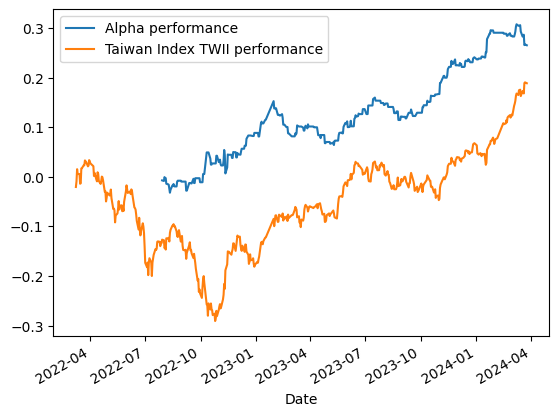

In [9]:
import matplotlib.pyplot as plt
fig = ( alpdf['position_since_last_close'] * (alpdf.returns) ).cumsum().plot(label = 'Alpha performance')
plt.plot( ((1) * alpdf.returns).cumsum() , label = 'Taiwan Index TWII performance')
plt.legend()
plt.xlabel('Date')
plt.show()

#### Future-Peeking Validation:
> Write down the latest alpha prediction, and compare it with addtional next-day info sent to the function.


#### Benefits:
#### 1. Logic of alpha is protected, and can be share with others!
#### 2. User can validate through challenging the function with custom data.

> ex. Checking Cloud_function( NDX(days=['20210101', '20220202']) )


#### 3. Long-Short neutral alpha of NDX index, which can be traded as future with low fee.